### Figures
1. CRC TF venn diagram
2. degree heatmap
3. CRC network

### Tables
1. CRC TF (paper vs recovered)

# Venn diagram 

In [325]:
import sys
import numpy as np
import pandas as pd
sys.path.append('/project/NeuralNet/software/miniconda3/envs/genetics/lib/python3.7/site-packages')

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

In [365]:
df = pd.DataFrame(np.array(["DE_paper", "DE_narrow.05_broad.05_exclNMtss", 30, 28, 25, 
                            "Beta_paper", "Beta_narrow.05_broad.1_incltss_cutoff500", 46, 32, 30, 
                            "Beta_paper", "HI-32_H3K27ac_incltss", 46, 62, 39, 
                            "Beta_paper", "HI-32_H3K27ac_incltss_cutoff500", 46, 34, 28, 
                            "Alpha_Beta_paper", "HI-32_H3K27ac_incltss", 60, 62, 46, 
                            "Alpha_Beta_paper", "HI-32_H3K27ac_incltss_cutoff500", 60, 34, 30,
                           ]).reshape(6, 5),
                  columns=["A", "B", "#A", "#B", "#AB"])

In [366]:
df = df.apply(pd.to_numeric, errors='ignore')
print(df.dtypes)
df

A      object
B      object
#A      int64
#B      int64
#AB     int64
dtype: object


A                                         B  #A  #B  #AB
0          DE_paper           DE_narrow.05_broad.05_exclNMtss  30  28   25
1        Beta_paper  Beta_narrow.05_broad.1_incltss_cutoff500  46  32   30
2        Beta_paper                     HI-32_H3K27ac_incltss  46  62   39
3        Beta_paper           HI-32_H3K27ac_incltss_cutoff500  46  34   28
4  Alpha_Beta_paper                     HI-32_H3K27ac_incltss  60  62   46
5  Alpha_Beta_paper           HI-32_H3K27ac_incltss_cutoff500  60  34   30

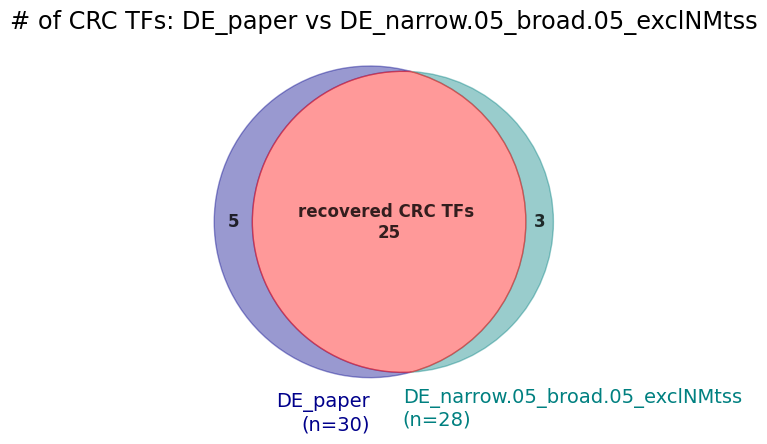

In [373]:
# Ab, aB, AB
# 10, 01, 11

v2 = venn2(subsets = {"10": (df['#A'] - df["#AB"])[0],
                      "01": (df['#B'] - df["#AB"])[0],
                      "11": df["#AB"][0]}, 
           set_labels = (f"{df.A[0]}\n(n={df['#A'][0]})", f"{df.B[0]}\n(n={df['#B'][0]})"))

colors = ["darkblue", "teal", "red"]
i = 0
for text in v2.set_labels:
    text.set_fontsize(14)                  #set label's fontsize 
    text.set_color(colors[i])                 #set label's font colour
    i += 1

IDs = ["10", "01", "11"]
i = 0
for ids in IDs:
    v2.get_patch_by_id(ids).set_color(colors[i])
    i += 1
    
for text in v2.subset_labels:
    text.set_fontsize(12)                #set circle's value fontsize 
    text.set_color('black')              #set circle's value font colour
    text.set_fontweight('bold')
    text.set_alpha(0.8)                    #set circle's value font transparency

v2.get_label_by_id('11').set_text(f'recovered CRC TFs \n{df["#AB"][0]}')

plt.title(f"# of CRC TFs: {df.A[0]} vs {df.B[0]}", fontsize='xx-large', loc="center") #set title
plt.show()

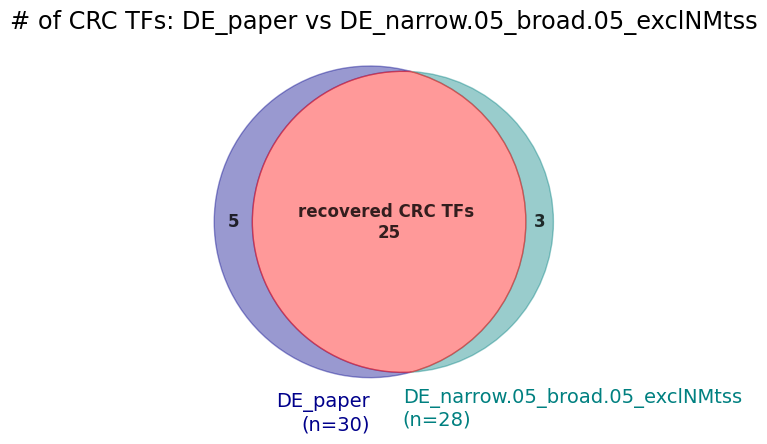

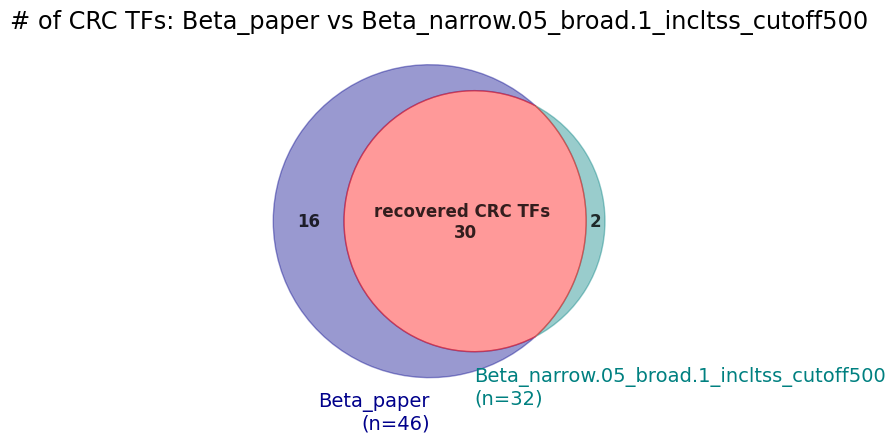

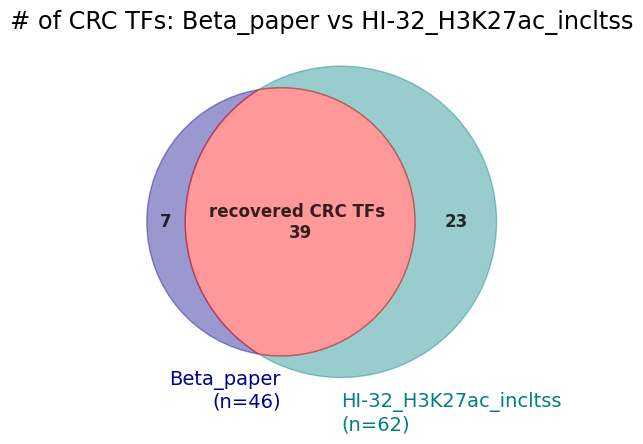

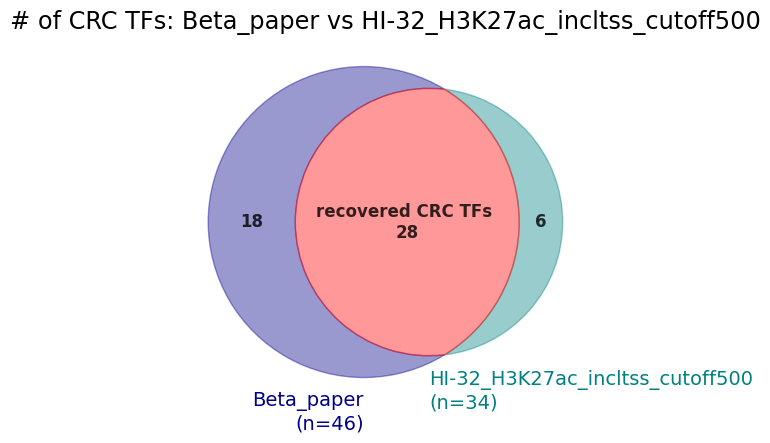

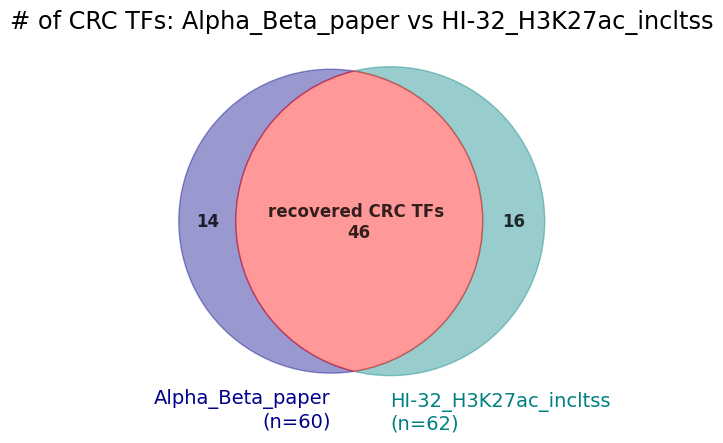

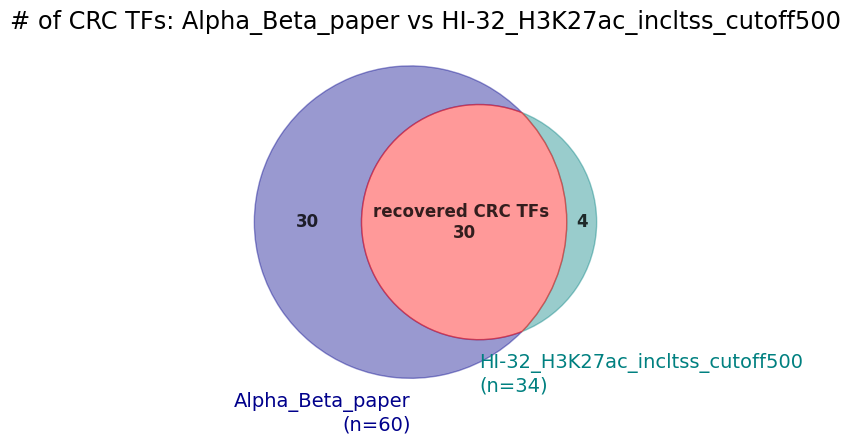

In [379]:
for i in range(df.shape[0]):
    # print(df.iloc[i])
    v2 = venn2(subsets = {"10": (df['#A'] - df["#AB"])[i],
                          "01": (df['#B'] - df["#AB"])[i],
                          "11": df["#AB"][i]}, 
               set_labels = (f"{df.A[i]}\n(n={df['#A'][i]})", f"{df.B[i]}\n(n={df['#B'][i]})"))
    
    colors = ["darkblue", "teal", "red"]
    j = 0
    for text in v2.set_labels:
        text.set_fontsize(14)                  #set label's fontsize 
        text.set_color(colors[j])                 #set label's font colour
        j += 1

    IDs = ["10", "01", "11"]
    j = 0
    for ids in IDs:
        v2.get_patch_by_id(ids).set_color(colors[j])
        j += 1
    
    for text in v2.subset_labels:
        text.set_fontsize(12)                #set circle's value fontsize 
        text.set_color('black')              #set circle's value font colour
        text.set_fontweight('bold')
        text.set_alpha(0.8)                    #set circle's value font transparency
        
    v2.get_label_by_id('11').set_text(f'recovered CRC TFs \n{df["#AB"][i]}')

    plt.title(f"# of CRC TFs: {df.A[i]} vs {df.B[i]}", fontsize='xx-large', loc="center") #set title
    plt.show()

# degree heatmap

In [2]:
# ref:
## plot heatmap: https://indianaiproduction.com/seaborn-heatmap/
## user-defined cmap: https://zhajiman.github.io/post/matplotlib_colormap/
## color name abbr: https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
## add legend to network: https://stackoverflow.com/questions/38534730/add-legend-to-networks-plot-to-explain-colouring-of-nodes

In [148]:
import sys
import openpyxl
import numpy as np
import pandas as pd
sys.path.append('/project/NeuralNet/software/miniconda3/envs/genetics/lib/python3.7/site-packages')


import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import networkx as nx
from sklearn.preprocessing import normalize
from networkx.algorithms.clique import find_cliques_recursive

In [422]:
def plotDegree(CRC, title, cmap, vmax=None):
    
    # get each clique from the CRC output
    cliqueList = []
    for i in CRC['CRC_TFs']:
        cliqueList.append(eval(i))
    print(f'first CRC is [{cliqueList[0]}]')
    
    # calculating degree for each node (TF) in the CRC
    ## degree of undirected graph
    ## including the degree of self-loop
    ## reason why using dict rather list: query speed of dictionary >> list

    ### 1. counting edges
    edgeCountDict = {}
    for clique in cliqueList:
        for TF in clique:
            for (source, target) in zip([TF] * len(clique), clique):
            # this for loop generate interactions (source, target) in each clique
                if (source, target) not in edgeCountDict.keys():
                    edgeCountDict[(source, target)] = 0
                else:
                    edgeCountDict[(source, target)] += 1
    
    ### 2. counting the occurrences of source nodes among edges => degree of nodes
    degreeDict = {}
    for (source, target) in edgeCountDict.keys():
        if source not in degreeDict.keys():
            degreeDict[source] = 1
        else:
            degreeDict[source] += 1
            
    ### 3. into sorted df
    degree = pd.DataFrame(degreeDict.items(), columns=['TF','degree'])
    # degree = pd.DataFrame.from_dict(degreeDict, orient='index')
    degree.sort_values(by=['degree', 'TF'], ascending=[False, True], inplace=True)
    print(f'top 5 TF: \n{degree.head(5)}')
    
    ### 4. plot degree heatmap
    plt.figure(figsize=(25,25), dpi=100)
    plt.title(title, fontsize=16)
    cbar_kws = {'shrink':0.5,}
    kwargs = {'alpha':.75, 'linewidths':0.5, 'linecolor':'k', 'cmap': cmap, 'vmin': 0, 'vmax': vmax,
              'clip_on':False, 'annot': True, 'fmt':'g', 'square': True, 'xticklabels': False,
              'yticklabels': degree['TF'].to_list(),
              'cbar_kws': cbar_kws}
    # sns.heatmap([degree['degree'].to_list()], **kwargs)
    sns.heatmap(np.array([degree['degree'].to_list()]).T, **kwargs)
    plt.yticks(rotation=0)
    # plt.savefig('./visualization/'+'_'.join(title.split())+'.pdf', dpi=100)
    plt.show()
    
    return degree, edgeCountDict



In [242]:
def plotNetwork(edgeCountDict, title, cmap, vmax=None):
    # in order to recreate similar network as in the paper, extract nodes of the network from the paper
    nodeListPaper = ['JUNB', 'ISL1', 'INSM1', 'HOXC4', 'GLIS3', 'FOXK1', 'BHLHE40', 'BHLHE41', 'ZBTB16', 'TFEB', 'SOX9', 'SOX11', 'RREB1', 'RARB', 'POU2F2', 'PKNOX2', 'PDX1', 'PAX6', 'PAX4', 'ONECUT1', 'NR4A2', 'NR3C1', 'NKX6-3', 'NKX6-1', 'MNX1', 'MEIS1', 'MAFA', 'MX1B', 'KLF3']
    edgeListPaper = []
    for pair in edgeCountDict.keys():
        if nodeListPaper.count(pair[0]) and nodeListPaper.count(pair[1]):
            edgeListPaper.append(pair)
    
    # constructing network
    title = title
    plt.figure(figsize=(12,10), dpi=100)
    plt.title(title, fontsize=16)
    G = nx.Graph()
    G.add_nodes_from(nodeListPaper)
    G.add_edges_from(edgeListPaper)
    pos = nx.circular_layout(G)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    node_color = [G.degree(v) for v in G]
    network = nx.draw_networkx_nodes(G, pos,node_color=node_color,cmap=mycmap, node_size=1200, vmin=0, vmax=vmax)
    plt.colorbar(network)
    plt.savefig('./visualization/'+'_'.join(title.split())+'.pdf', dpi=100)

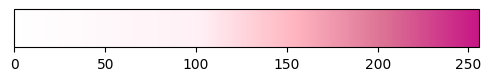

In [211]:
def show_cmap(cmap, norm=None, extend=None):
    '''展示一个colormap.'''
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=cmap.N)
    im = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    fig.colorbar(im, cax=ax, orientation='horizontal', extend=extend)
    plt.show()

colors = ['white', 'lavenderblush', 'lightpink', 'palevioletred', 'mediumvioletred']
nodes = [0, 0.4, 0.6, 0.8, 1]
BetaDegreeCmap = mcolors.LinearSegmentedColormap.from_list('cmap1', list(zip(nodes, colors)))
show_cmap(BetaDegreeCmap)

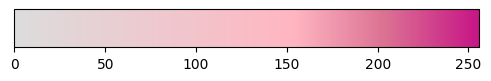

In [212]:
colors = ['gainsboro', 'lightpink', 'palevioletred', 'mediumvioletred']
nodes = [0, 0.6, 0.8, 1]
BetaCRCcmap = mcolors.LinearSegmentedColormap.from_list('cmap1', list(zip(nodes, colors)))
show_cmap(BetaCRCcmap)

## degree heatmap of Beta cell (paper)

In [333]:
wb = pd.ExcelFile('/home/jieyidi/Downloads/Meissner2019/1-s2.0-S1934590919304667-mmc7_CRC.xlsx')
wb.sheet_names

['hPSC', 'DE', 'PP1', 'PP2', 'EN', 'SC-beta', 'PH', 'Alpha', 'Beta']

In [433]:
betaCRCinPaper = wb.parse('Beta')
betaCRCinPaper.head(5)

CRC#                                            CRC_TFs       score  #TFs
0     1  ['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'M...  412.705882    17
1     2  ['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'M...  411.823529    17
2     3  ['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'M...  400.705882    17
3     4  ['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'M...  400.312500    16
4     5  ['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'M...  399.823529    17

first CRC is [['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'MEIS2', 'PDX1', 'PAX6', 'MEF2D', 'SMAD3', 'NFE2L2', 'INSM1', 'RFX2', 'KLF13', 'RARA', 'SOX13', 'NKX2-2']]
top 5 TF: 
       TF  degree
2   FOXA2      45
0   FOXK1      45
26  TEAD1      45
11  INSM1      44
5   MEIS2      44


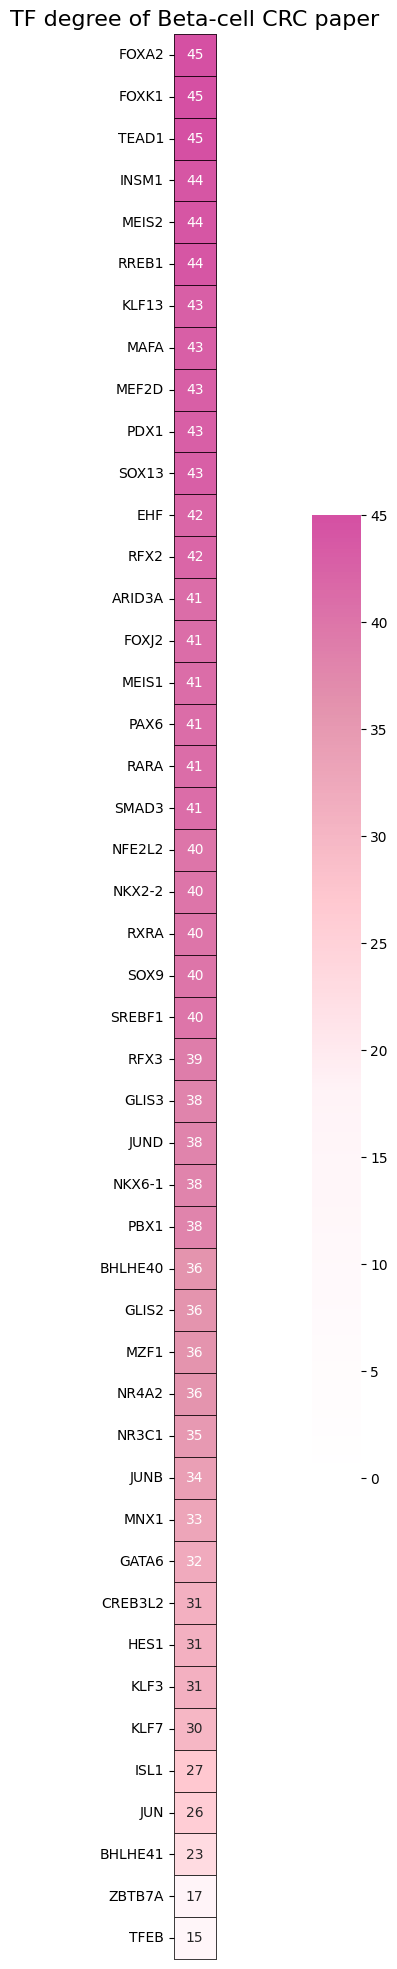

In [434]:
title = 'TF degree of Beta-cell CRC paper'
degree_paper, edgeCountDict = plotDegree(CRC = betaCRCinPaper, title = title, cmap = BetaDegreeCmap)

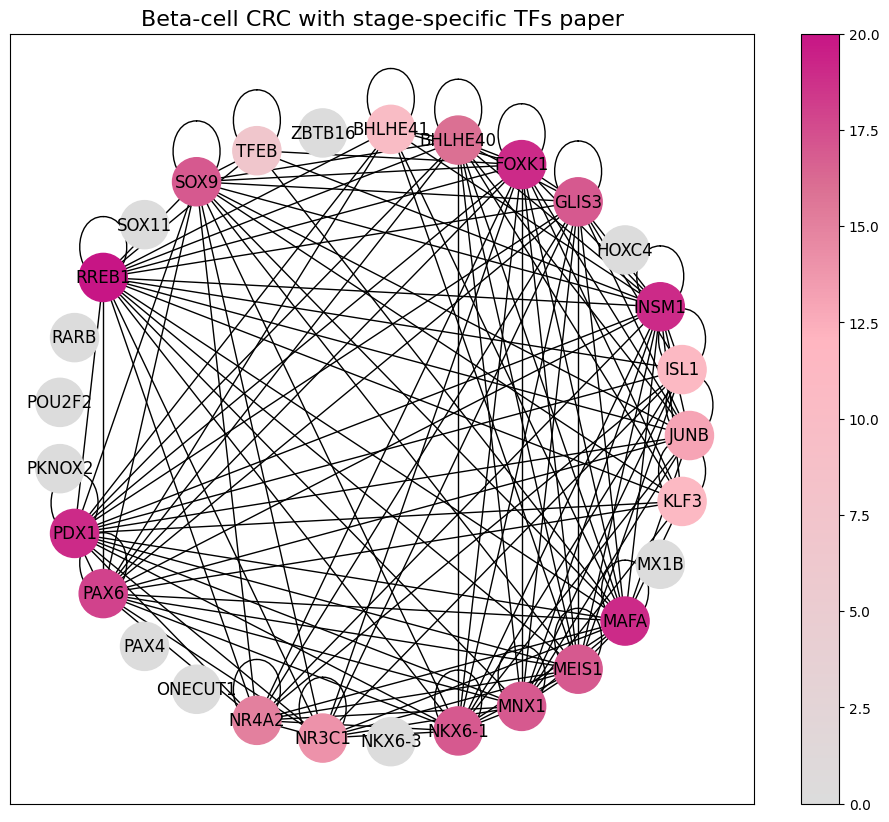

In [339]:
title = 'Beta-cell CRC with stage-specific TFs paper'
plotNetwork(edgeCountDict=edgeCountDict, title=title, cmap=BetaCRCcmap)

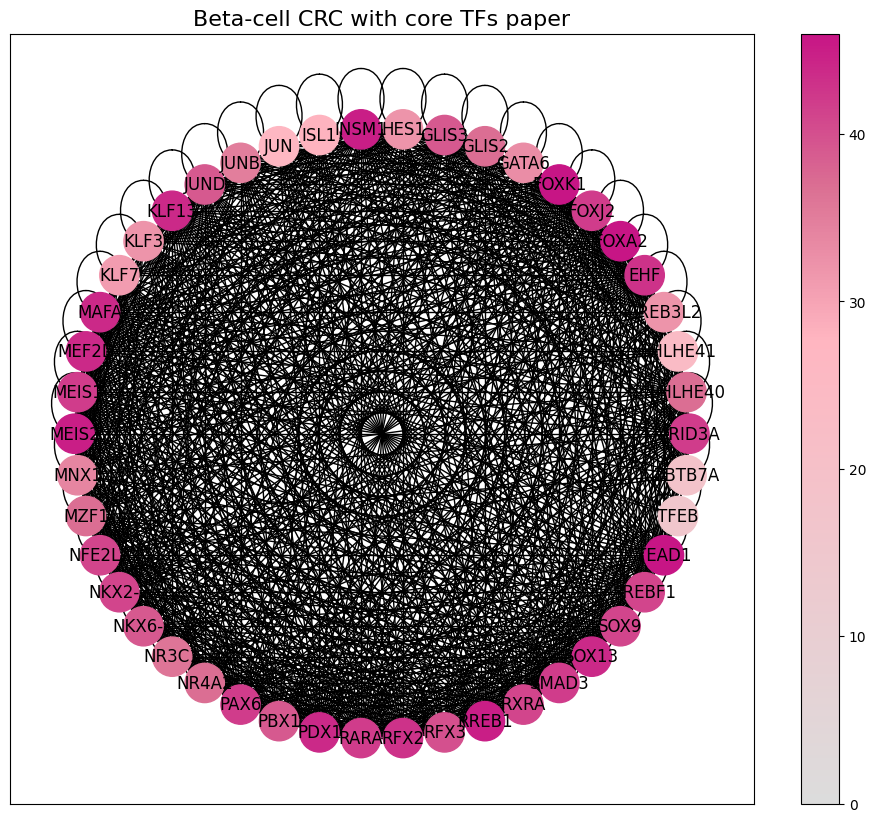

In [341]:
# DE CRC composed of all autoregulatory TFs
nodeList = sorted(degree['TF'].to_list())

edgeList = []
for pair in edgeCountDict.keys():
    edgeList.append(pair)

# constructing network
title = 'Beta-cell CRC with core TFs paper'
plt.figure(figsize=(12,10), dpi=100)
plt.title(title, fontsize=16)
G = nx.Graph()
G.add_nodes_from(nodeList)
G.add_edges_from(edgeList)
pos = nx.circular_layout(G)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
node_color = [G.degree(v) for v in G]
network = nx.draw_networkx_nodes(G, pos,node_color=node_color,cmap=mycmap, node_size=800, vmin=0)
plt.colorbar(network)
plt.savefig('./visualization/'+'_'.join(title.split())+'.pdf', dpi=100)
# plt.show()

## degree heatmap of Beta cell (recapitulation)

In [418]:
betaCRC = pd.read_csv('./CRCmapper/2-2.crc_Beta_narrow.05_broad.1_incltss_cutoff500/Beta_CRC_SCORES.txt', 
                      header = None, sep = '\t', names = ['CRC_TFs', 'score', '#TFs'])
betaCRC.head(5)

CRC_TFs       score  #TFs
0  ['FOXK1', 'SOX9', 'RFX1', 'FOXJ2', 'RARA', 'BH...  150.888889     9
1  ['FOXK1', 'SOX9', 'RFX1', 'FOXJ2', 'ARID3A', '...  147.818182    11
2  ['FOXK1', 'SOX9', 'RFX1', 'FOXJ2', 'ARID3A', '...  147.636364    11
3  ['FOXK1', 'SOX9', 'RFX1', 'FOXJ2', 'RARA', 'GL...  147.000000    12
4  ['FOXK1', 'SOX9', 'RFX1', 'FOXJ2', 'DBP', 'MZF...  146.900000    10

first CRC is [['FOXK1', 'SOX9', 'RFX1', 'FOXJ2', 'RARA', 'BHLHE40', 'JUND', 'KLF13', 'MEIS2']]
top 5 TF: 
      TF  degree
0  FOXK1      30
4   RARA      29
2   RFX1      29
1   SOX9      29
3  FOXJ2      28


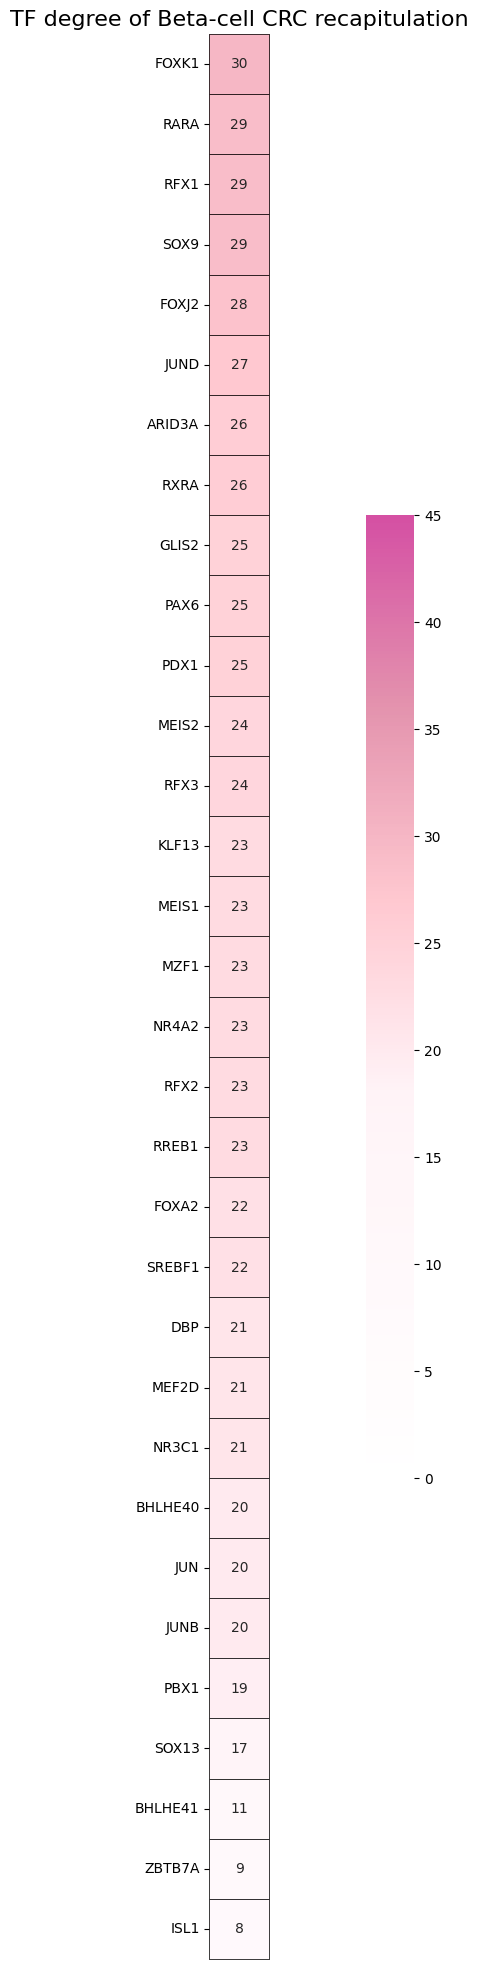

In [435]:
title = 'TF degree of Beta-cell CRC recapitulation'
degree_recap, edgeCountDict = plotDegree(CRC = betaCRC, title = title, cmap = BetaDegreeCmap, vmax=45)

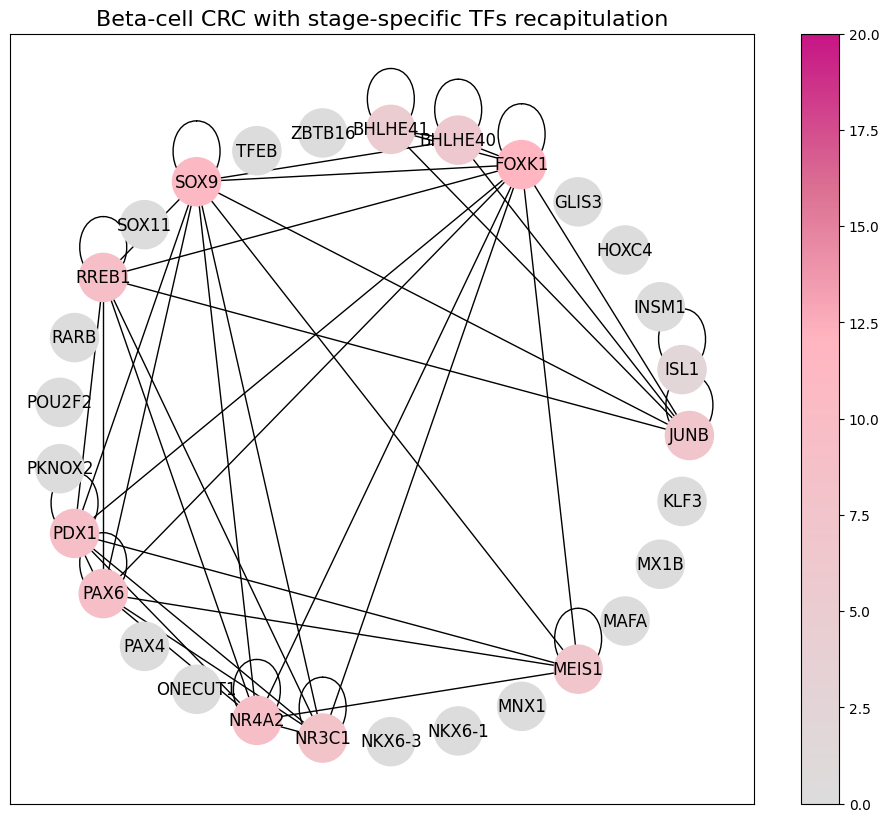

In [344]:
title = 'Beta-cell CRC with stage-specific TFs recapitulation'
plotNetwork(edgeCountDict=edgeCountDict, title=title, cmap=BetaCRCcmap, vmax=20)

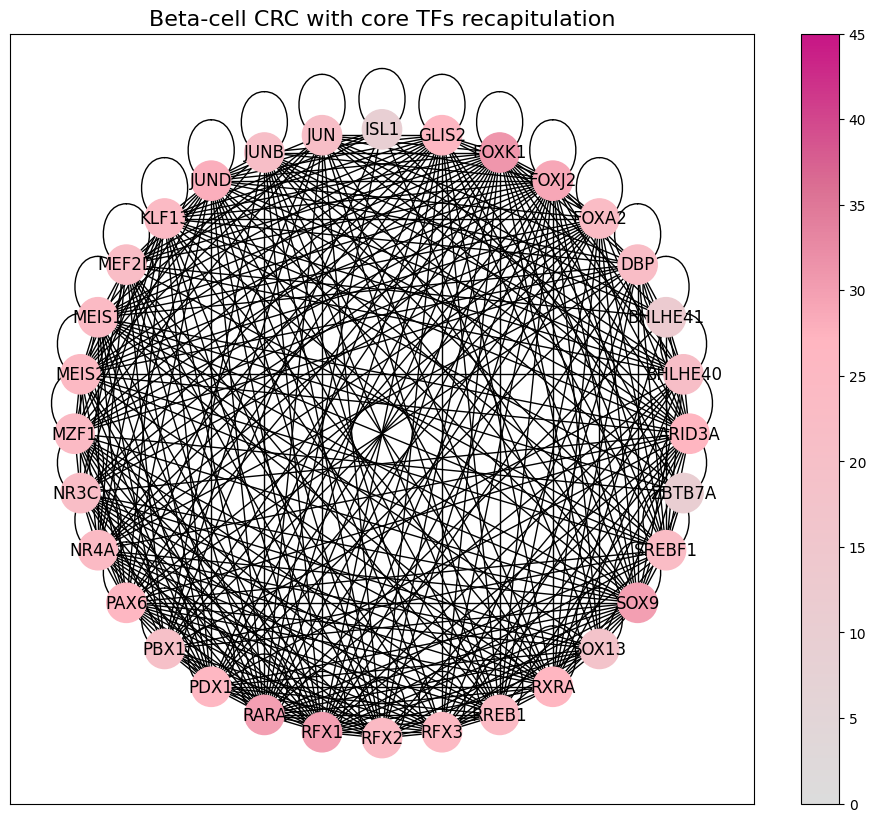

In [345]:
# DE CRC composed of all autoregulatory TFs
nodeList = sorted(degree['TF'].to_list())

edgeList = []
for pair in edgeCountDict.keys():
    edgeList.append(pair)

# constructing network
title = 'Beta-cell CRC with core TFs recapitulation'
plt.figure(figsize=(12,10), dpi=100)
plt.title(title, fontsize=16)
G = nx.Graph()
G.add_nodes_from(nodeList)
G.add_edges_from(edgeList)
pos = nx.circular_layout(G)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
node_color = [G.degree(v) for v in G]
network = nx.draw_networkx_nodes(G, pos,node_color=node_color,cmap=mycmap, node_size=800, vmin=0, vmax=45)
plt.colorbar(network)
plt.savefig('./visualization/'+'_'.join(title.split())+'.pdf', dpi=100)
# plt.show()

In [438]:
degree_paper['rank'] = degree_paper.degree.rank(method="min", ascending=False)
print(degree_paper)

         TF  degree  rank
2     FOXA2      45   1.0
0     FOXK1      45   1.0
26    TEAD1      45   1.0
11    INSM1      44   4.0
5     MEIS2      44   4.0
4     RREB1      44   4.0
13    KLF13      43   7.0
3      MAFA      43   7.0
8     MEF2D      43   7.0
6      PDX1      43   7.0
15    SOX13      43   7.0
34      EHF      42  12.0
12     RFX2      42  12.0
18   ARID3A      41  14.0
17    FOXJ2      41  14.0
29    MEIS1      41  14.0
7      PAX6      41  14.0
14     RARA      41  14.0
9     SMAD3      41  14.0
10   NFE2L2      40  20.0
16   NKX2-2      40  20.0
20     RXRA      40  20.0
30     SOX9      40  20.0
28   SREBF1      40  20.0
36     RFX3      39  25.0
27    GLIS3      38  26.0
24     JUND      38  26.0
31   NKX6-1      38  26.0
32     PBX1      38  26.0
37  BHLHE40      36  30.0
21    GLIS2      36  30.0
25     MZF1      36  30.0
33    NR4A2      36  30.0
19    NR3C1      35  34.0
22     JUNB      34  35.0
40     MNX1      33  36.0
23    GATA6      32  37.0
39  CREB3L2 

In [439]:
degree_recap['rank'] = degree_recap.degree.rank(method="min", ascending=False)
print(degree_recap)

         TF  degree  rank
0     FOXK1      30   1.0
4      RARA      29   2.0
2      RFX1      29   2.0
1      SOX9      29   2.0
3     FOXJ2      28   5.0
6      JUND      27   6.0
9    ARID3A      26   7.0
20     RXRA      26   7.0
14    GLIS2      25   9.0
22     PAX6      25   9.0
12     PDX1      25   9.0
8     MEIS2      24  12.0
21     RFX3      24  12.0
7     KLF13      23  14.0
18    MEIS1      23  14.0
16     MZF1      23  14.0
11    NR4A2      23  14.0
19     RFX2      23  14.0
13    RREB1      23  14.0
10    FOXA2      22  20.0
23   SREBF1      22  20.0
15      DBP      21  22.0
28    MEF2D      21  22.0
26    NR3C1      21  22.0
5   BHLHE40      20  25.0
17      JUN      20  25.0
24     JUNB      20  25.0
27     PBX1      19  28.0
25    SOX13      17  29.0
31  BHLHE41      11  30.0
29   ZBTB7A       9  31.0
30     ISL1       8  32.0


In [441]:
pd.merge(degree_paper, degree_recap, on="TF", how="outer", suffixes=('_paper', '_recapitulation')).fillna('-')


TF degree_paper rank_paper degree_recapitulation rank_recapitulation
0     FOXA2         45.0        1.0                  22.0                20.0
1     FOXK1         45.0        1.0                  30.0                 1.0
2     TEAD1         45.0        1.0                     -                   -
3     INSM1         44.0        4.0                     -                   -
4     MEIS2         44.0        4.0                  24.0                12.0
5     RREB1         44.0        4.0                  23.0                14.0
6     KLF13         43.0        7.0                  23.0                14.0
7      MAFA         43.0        7.0                     -                   -
8     MEF2D         43.0        7.0                  21.0                22.0
9      PDX1         43.0        7.0                  25.0                 9.0
10    SOX13         43.0        7.0                  17.0                29.0
11      EHF         42.0       12.0                     -                   -
12     RFX2         42.0       12.0                  23.0                14.0
13   ARID3A         41.0       14.0                  26.0                 7.0
14    FOXJ2         41.0       14.0                  28.0                 5.0
15    MEIS1         41.0       14.0                  23.0                14.0
16     PAX6         41.0       14.0                  25.0                 9.0
17     RARA         41.0       14.0                  29.0                 2.0
18    SMAD3         41.0       14.0                     -                   -
19   NFE2L2         40.0       20.0                     -                   -
20   NKX2-2         40.0       20.0                     -                   -
21     RXRA         40.0       20.0                  26.0                 7.0
22     SOX9         40.0       20.0                  29.0                 2.0
23   SREBF1         40.0       20.0                  22.0                20.0
24     RFX3         39.0       25.0                  24.0                12.0
25    GLIS3         38.0       26.0                     -                   -
26     JUND         38.0       26.0                  27.0                 6.0
27   NKX6-1         38.0       26.0                     -                   -
28     PBX1         38.0       26.0                  19.0                28.0
29  BHLHE40         36.0       30.0                  20.0                25.0
30    GLIS2         36.0       30.0                  25.0                 9.0
31     MZF1         36.0       30.0                  23.0                14.0
32    NR4A2         36.0       30.0                  23.0                14.0
33    NR3C1         35.0       34.0                  21.0                22.0
34     JUNB         34.0       35.0                  20.0                25.0
35     MNX1         33.0       36.0                     -                   -
36    GATA6         32.0       37.0                     -                   -
37  CREB3L2         31.0       38.0                     -                   -
38     HES1         31.0       38.0                     -                   -
39     KLF3         31.0       38.0                     -                   -
40     KLF7         30.0       41.0                     -                   -
41     ISL1         27.0       42.0                   8.0                32.0
42      JUN         26.0       43.0                  20.0                25.0
43  BHLHE41         23.0       44.0                  11.0                30.0
44   ZBTB7A         17.0       45.0                   9.0                31.0
45     TFEB         15.0       46.0                     -                   -
46     RFX1            -          -                  29.0                 2.0
47      DBP            -          -                  21.0                22.0

## degree heatmap of Beta cell (HI-32_H3K27ac)

In [442]:
HI32_CRC = pd.read_csv('./CRCmapper/1-1.crc_HI-32_K27ac_incltss/H3K27ac_HI-32_CRC_SCORES.txt', 
                      header = None, sep = '\t', names = ['CRC_TFs', 'score', '#TFs'])
HI32_CRC.head(5)

CRC_TFs        score  #TFs
0  ['SOX9', 'MEIS1', 'RREB1', 'MEIS2', 'EHF', 'RF...  1005.086957    23
1  ['SOX9', 'MEIS1', 'RREB1', 'MEIS2', 'EHF', 'RF...  1004.071429    28
2  ['SOX9', 'MEIS1', 'RREB1', 'MEIS2', 'EHF', 'RF...  1000.481481    27
3  ['SOX9', 'MEIS1', 'RREB1', 'MEIS2', 'EHF', 'RF...   999.518519    27
4  ['SOX9', 'MEIS1', 'RREB1', 'MEIS2', 'EHF', 'RF...   998.777778    27

first CRC is [['SOX9', 'MEIS1', 'RREB1', 'MEIS2', 'EHF', 'RFX2', 'TEAD1', 'FOXA2', 'FOXK1', 'ARID3A', 'MAFB', 'GLIS3', 'ETS1', 'NKX6-1', 'TFEB', 'KLF13', 'RXRG', 'PBX1', 'GATA6', 'INSM1', 'FOXP2', 'MNX1', 'ELF3']]
top 5 TF: 
      TF  degree
4    EHF      62
7  FOXA2      62
1  MEIS1      62
3  MEIS2      62
5   RFX2      62


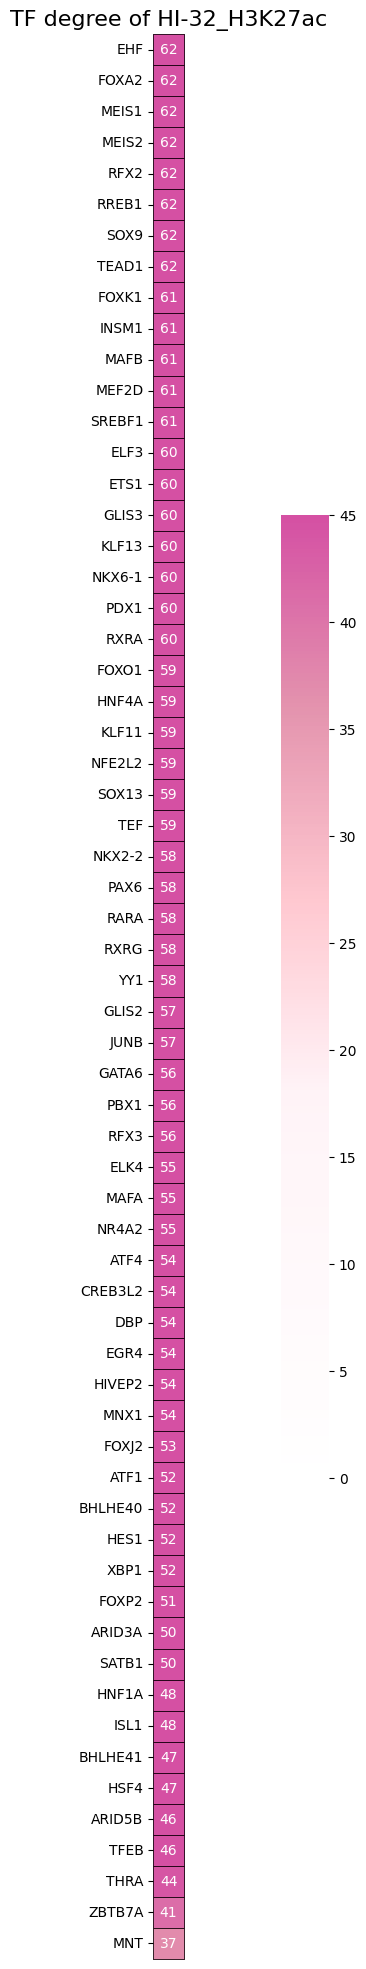

In [443]:
title = 'TF degree of HI-32_H3K27ac'
degree_HI32, edgeCountDict = plotDegree(CRC = HI32_CRC, cmap = BetaDegreeCmap, title=title, vmax=45)

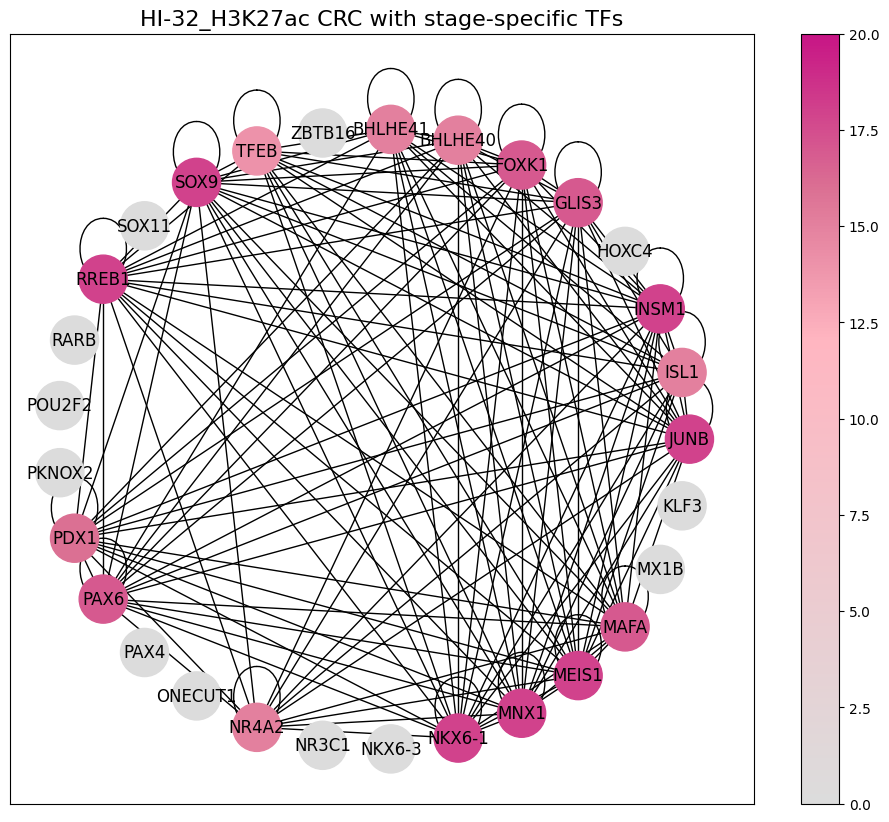

In [348]:
title = 'HI-32_H3K27ac CRC with stage-specific TFs'
plotNetwork(edgeCountDict=edgeCountDict, title=title, cmap=BetaCRCcmap, vmax=20)

## degree heatmap of Beta cell (HI-32_H3K27ac_cutoff500)

In [349]:
HI32_cutoff500_CRC = pd.read_csv('./CRCmapper/1-1.crc_HI-32_K27ac_incltss_cutoff500/H3K27ac_HI-32_CRC_SCORES.txt', 
                      header = None, sep = '\t', names = ['CRC_TFs', 'score', '#TFs'])
HI32_cutoff500_CRC.head(5)

CRC_TFs      score  #TFs
0  ['FOXK1', 'MEIS1', 'MAFB', 'TEAD1', 'RREB1', '...  78.666667    18
1  ['FOXK1', 'MEIS1', 'MAFB', 'TEAD1', 'RREB1', '...  78.631579    19
2  ['FOXK1', 'MEIS1', 'MAFB', 'TEAD1', 'RREB1', '...  78.555556    18
3  ['FOXK1', 'MEIS1', 'MAFB', 'TEAD1', 'RREB1', '...  78.210526    19
4  ['FOXK1', 'MEIS1', 'MAFB', 'TEAD1', 'RREB1', '...  78.111111    18

first CRC is [['FOXK1', 'MEIS1', 'MAFB', 'TEAD1', 'RREB1', 'KLF11', 'MEIS2', 'FOXA2', 'EHF', 'RFX2', 'SREBF1', 'ISL1', 'NKX6-1', 'KLF13', 'TFEB', 'PBX1', 'MEF2D', 'ARID5B']]
top 5 TF: 
      TF  degree
8    EHF      34
7  FOXA2      34
0  FOXK1      34
5  KLF11      34
2   MAFB      34


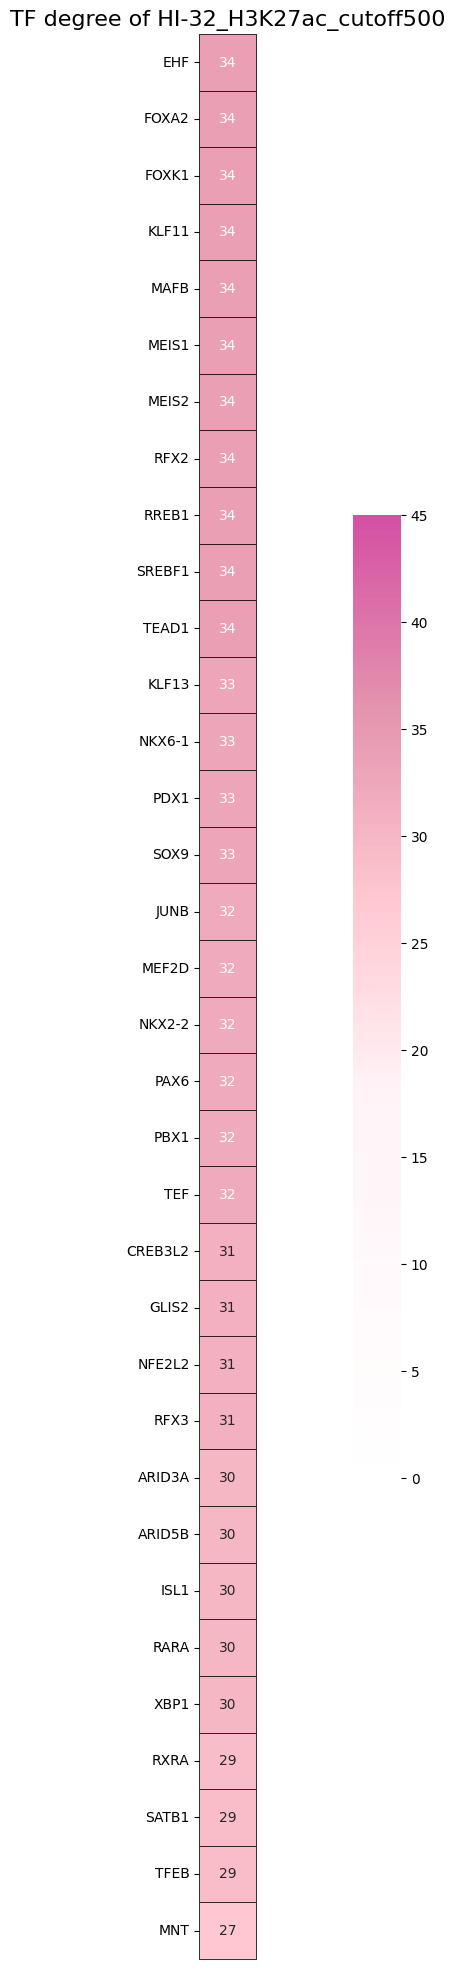

In [350]:
title = 'TF degree of HI-32_H3K27ac_cutoff500'
degree, edgeCountDict = plotDegree(CRC = HI32_cutoff500_CRC, cmap = BetaDegreeCmap, title=title, vmax=45)

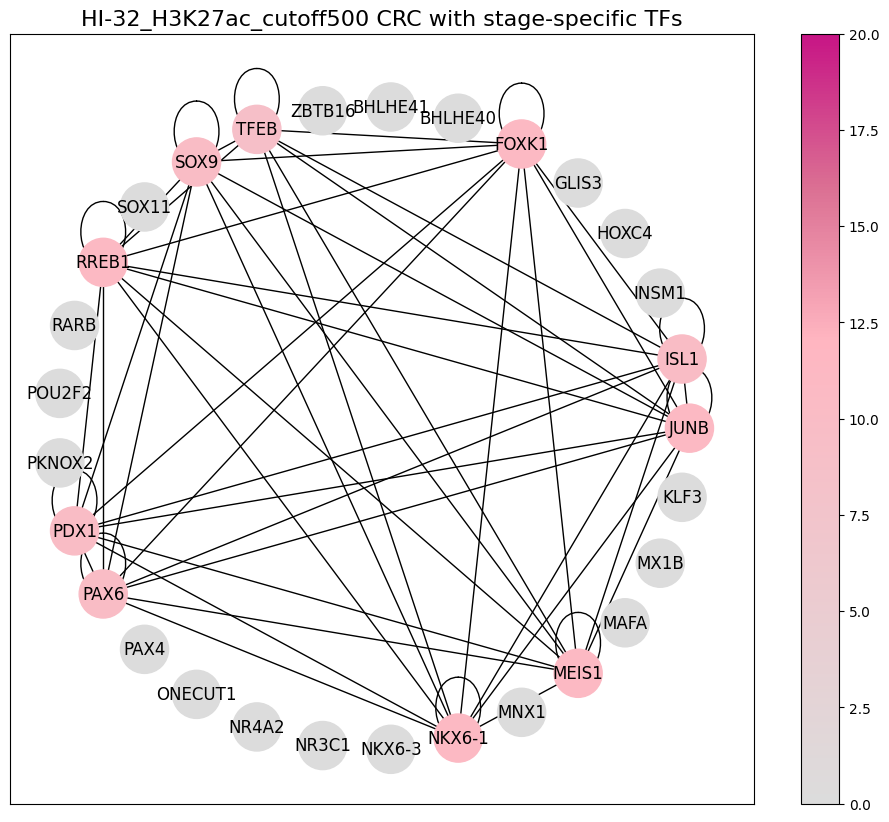

In [351]:
title = 'HI-32_H3K27ac_cutoff500 CRC with stage-specific TFs'
plotNetwork(edgeCountDict=edgeCountDict, title=title, cmap=BetaCRCcmap, vmax=20)

In [445]:
degree_HI32['rank'] = degree_HI32.degree.rank(method="min", ascending=False)
display(degree_HI32)

TF  degree  rank
4      EHF      62   1.0
7    FOXA2      62   1.0
1    MEIS1      62   1.0
3    MEIS2      62   1.0
5     RFX2      62   1.0
..     ...     ...   ...
25  ARID5B      46  58.0
14    TFEB      46  58.0
52    THRA      44  60.0
61  ZBTB7A      41  61.0
51     MNT      37  62.0

[62 rows x 3 columns]

In [450]:
pd.merge(degree_paper, degree_HI32, on="TF", how="outer", suffixes=('_paper', '_HI32')).fillna('-')[:35]


TF degree_paper rank_paper degree_HI32 rank_HI32
0     FOXA2         45.0        1.0        62.0       1.0
1     FOXK1         45.0        1.0        61.0       9.0
2     TEAD1         45.0        1.0        62.0       1.0
3     INSM1         44.0        4.0        61.0       9.0
4     MEIS2         44.0        4.0        62.0       1.0
5     RREB1         44.0        4.0        62.0       1.0
6     KLF13         43.0        7.0        60.0      14.0
7      MAFA         43.0        7.0        55.0      37.0
8     MEF2D         43.0        7.0        61.0       9.0
9      PDX1         43.0        7.0        60.0      14.0
10    SOX13         43.0        7.0        59.0      21.0
11      EHF         42.0       12.0        62.0       1.0
12     RFX2         42.0       12.0        62.0       1.0
13   ARID3A         41.0       14.0        50.0      52.0
14    FOXJ2         41.0       14.0        53.0      46.0
15    MEIS1         41.0       14.0        62.0       1.0
16     PAX6         41.0       14.0        58.0      27.0
17     RARA         41.0       14.0        58.0      27.0
18    SMAD3         41.0       14.0           -         -
19   NFE2L2         40.0       20.0        59.0      21.0
20   NKX2-2         40.0       20.0        58.0      27.0
21     RXRA         40.0       20.0        60.0      14.0
22     SOX9         40.0       20.0        62.0       1.0
23   SREBF1         40.0       20.0        61.0       9.0
24     RFX3         39.0       25.0        56.0      34.0
25    GLIS3         38.0       26.0        60.0      14.0
26     JUND         38.0       26.0           -         -
27   NKX6-1         38.0       26.0        60.0      14.0
28     PBX1         38.0       26.0        56.0      34.0
29  BHLHE40         36.0       30.0        52.0      47.0
30    GLIS2         36.0       30.0        57.0      32.0
31     MZF1         36.0       30.0           -         -
32    NR4A2         36.0       30.0        55.0      37.0
33    NR3C1         35.0       34.0           -         -
34     JUNB         34.0       35.0        57.0      32.0

In [451]:
pd.merge(degree_paper, degree_HI32, on="TF", how="outer", suffixes=('_paper', '_HI32')).fillna('-')[35:]

TF degree_paper rank_paper degree_HI32 rank_HI32
35     MNX1         33.0       36.0        54.0      40.0
36    GATA6         32.0       37.0        56.0      34.0
37  CREB3L2         31.0       38.0        54.0      40.0
38     HES1         31.0       38.0        52.0      47.0
39     KLF3         31.0       38.0           -         -
40     KLF7         30.0       41.0           -         -
41     ISL1         27.0       42.0        48.0      54.0
42      JUN         26.0       43.0           -         -
43  BHLHE41         23.0       44.0        47.0      56.0
44   ZBTB7A         17.0       45.0        41.0      61.0
45     TFEB         15.0       46.0        46.0      58.0
46     MAFB            -          -        61.0       9.0
47     ELF3            -          -        60.0      14.0
48     ETS1            -          -        60.0      14.0
49    FOXO1            -          -        59.0      21.0
50    HNF4A            -          -        59.0      21.0
51    KLF11            -          -        59.0      21.0
52      TEF            -          -        59.0      21.0
53     RXRG            -          -        58.0      27.0
54      YY1            -          -        58.0      27.0
55     ELK4            -          -        55.0      37.0
56     ATF4            -          -        54.0      40.0
57      DBP            -          -        54.0      40.0
58     EGR4            -          -        54.0      40.0
59   HIVEP2            -          -        54.0      40.0
60     ATF1            -          -        52.0      47.0
61     XBP1            -          -        52.0      47.0
62    FOXP2            -          -        51.0      51.0
63    SATB1            -          -        50.0      52.0
64    HNF1A            -          -        48.0      54.0
65     HSF4            -          -        47.0      56.0
66   ARID5B            -          -        46.0      58.0
67     THRA            -          -        44.0      60.0
68      MNT            -          -        37.0      62.0

## degree heatmap of DE (paper)

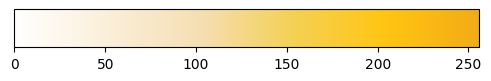

In [352]:
colors = ['white', 'wheat', 'xkcd:maize', 'xkcd:sunflower', 'xkcd:squash']
nodes = [0, 0.4, 0.6, 0.8, 1]
deDegreeCmap = mcolors.LinearSegmentedColormap.from_list('cmap1', list(zip(nodes, colors)))
show_cmap(deDegreeCmap)

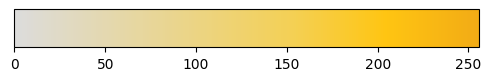

In [357]:
colors = ['gainsboro', 'xkcd:maize', 'xkcd:sunflower', 'xkcd:squash']
nodes = [0, 0.6, 0.8, 1]
deCRCcmap = mcolors.LinearSegmentedColormap.from_list('cmap1', list(zip(nodes, colors)))
show_cmap(deCRCcmap)

In [358]:
wb = pd.ExcelFile('/home/jieyidi/Downloads/Meissner2019/1-s2.0-S1934590919304667-mmc7_CRC.xlsx')
wb.sheet_names

['hPSC', 'DE', 'PP1', 'PP2', 'EN', 'SC-beta', 'PH', 'Alpha', 'Beta']

In [381]:
deCRCinPaper = wb.parse('DE')
deCRCinPaper.head(5)

CRC#                                            CRC_TFs      score  #TFs
0     1  ['ZIC3', 'FOXA2', 'YY1', 'KLF7', 'TCF7L2', 'SO...  48.076923    13
1     2  ['ZIC3', 'FOXA2', 'YY1', 'KLF7', 'TCF7L2', 'SO...  47.692308    13
2     3  ['ZIC3', 'FOXA2', 'YY1', 'KLF7', 'TCF7L2', 'SO...  47.461538    13
3     4  ['ZIC3', 'FOXA2', 'YY1', 'KLF7', 'TCF7L2', 'SO...  47.076923    13
4     5  ['ZIC3', 'FOXA2', 'YY1', 'KLF7', 'TCF7L2', 'SO...  46.800000    15

first CRC is [['ZIC3', 'FOXA2', 'YY1', 'KLF7', 'TCF7L2', 'SOX4', 'EOMES', 'OTX2', 'FOXO3', 'TCF7L1', 'SOX17', 'JUND', 'ZIC2']]
top 5 TF: 
       TF  degree
0    ZIC3      28
1   FOXA2      27
4  TCF7L2      27
3    KLF7      26
7    OTX2      26


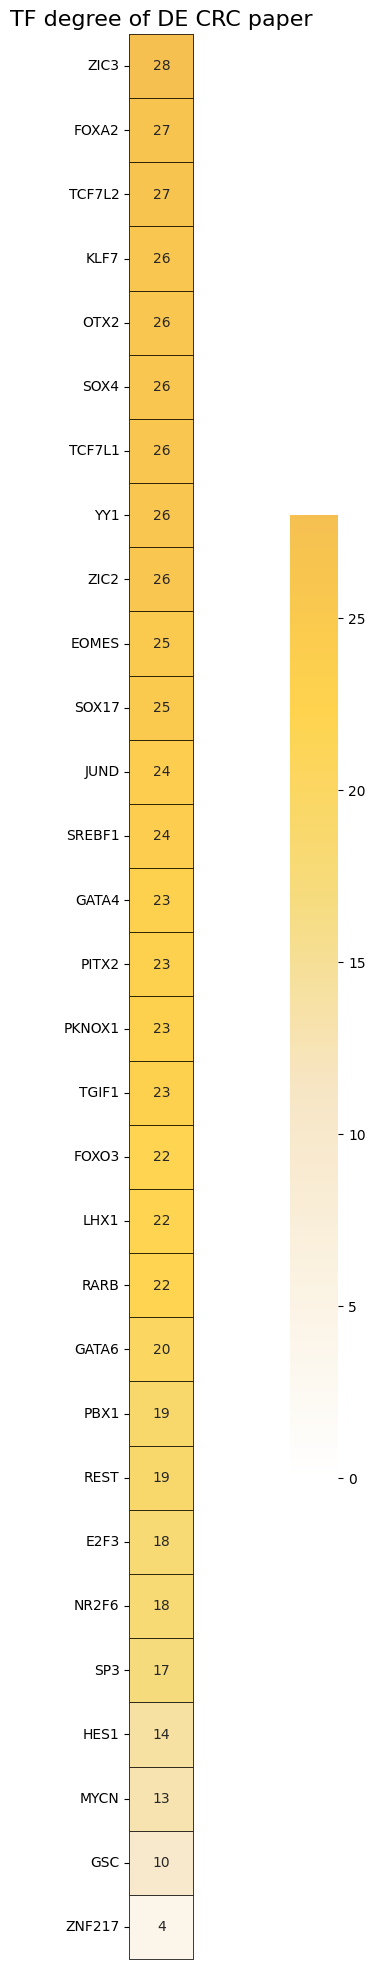

In [406]:
title = 'TF degree of DE CRC paper'
degree_paper, edgeCountDict = plotDegree(CRC = deCRCinPaper, title = title, cmap = deDegreeCmap, vmax=28)

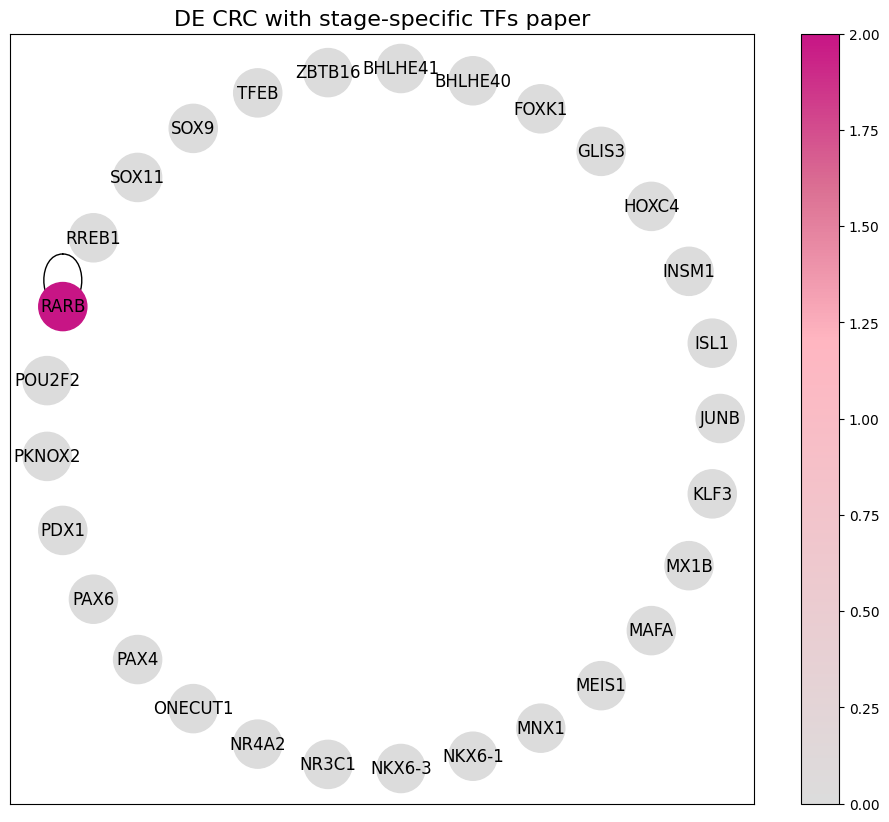

In [356]:
title = 'DE CRC with stage-specific TFs paper'
plotNetwork(edgeCountDict=edgeCountDict, title=title, cmap=BetaCRCcmap)

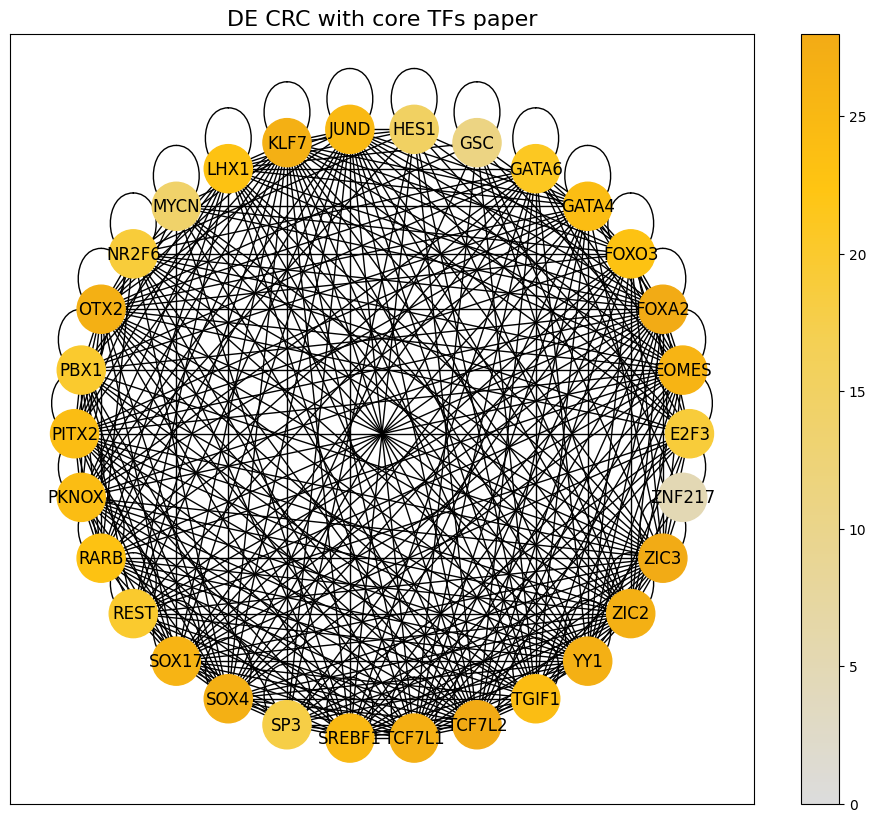

In [360]:
# DE CRC composed of all autoregulatory TFs
nodeList = sorted(degree['TF'].to_list())

edgeList = []
for pair in edgeCountDict.keys():
    edgeList.append(pair)

# constructing network
title = 'DE CRC with core TFs paper'
plt.figure(figsize=(12,10), dpi=100)
plt.title(title, fontsize=16)
G = nx.Graph()
G.add_nodes_from(nodeList)
G.add_edges_from(edgeList)
pos = nx.circular_layout(G)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
node_color = [G.degree(v) for v in G]
network = nx.draw_networkx_nodes(G, pos,node_color=node_color,cmap=deCRCcmap, node_size=1200, vmin=0, vmax=28)
plt.colorbar(network)
plt.savefig('./visualization/'+'_'.join(title.split())+'.pdf', dpi=100)

## degree heatmap of DE (racapitulation)

In [361]:
deCRC = pd.read_csv('./CRCmapper/6.crc_DE_narrow.05_broad.05_exclNMtss/DE_CRC_SCORES.txt', 
                      header = None, sep = '\t', names = ['CRC_TFs', 'score', '#TFs'])
deCRC.head(5)

CRC_TFs      score  #TFs
0  ['ZIC3', 'ZIC2', 'TCF7L2', 'LHX1', 'OTX2', 'EO...  29.500000    10
1  ['ZIC3', 'ZIC2', 'TCF7L2', 'LHX1', 'OTX2', 'EO...  28.000000    11
2  ['ZIC3', 'ZIC2', 'TCF7L2', 'KLF7', 'RARB', 'OT...  27.833333    12
3  ['GATA4', 'FOXA2', 'TCF7L2', 'ZIC2', 'OTX2', '...  27.777778     9
4  ['ZIC3', 'ZIC2', 'TCF7L2', 'SALL2', 'OTX2', 'E...  27.750000     8

first CRC is [['ZIC3', 'ZIC2', 'TCF7L2', 'LHX1', 'OTX2', 'EOMES', 'PITX2', 'SOX4', 'TCF7L1', 'FOXA2']]
top 5 TF: 
       TF  degree
0    ZIC3      26
1    ZIC2      25
2  TCF7L2      24
9   FOXA2      23
4    OTX2      23


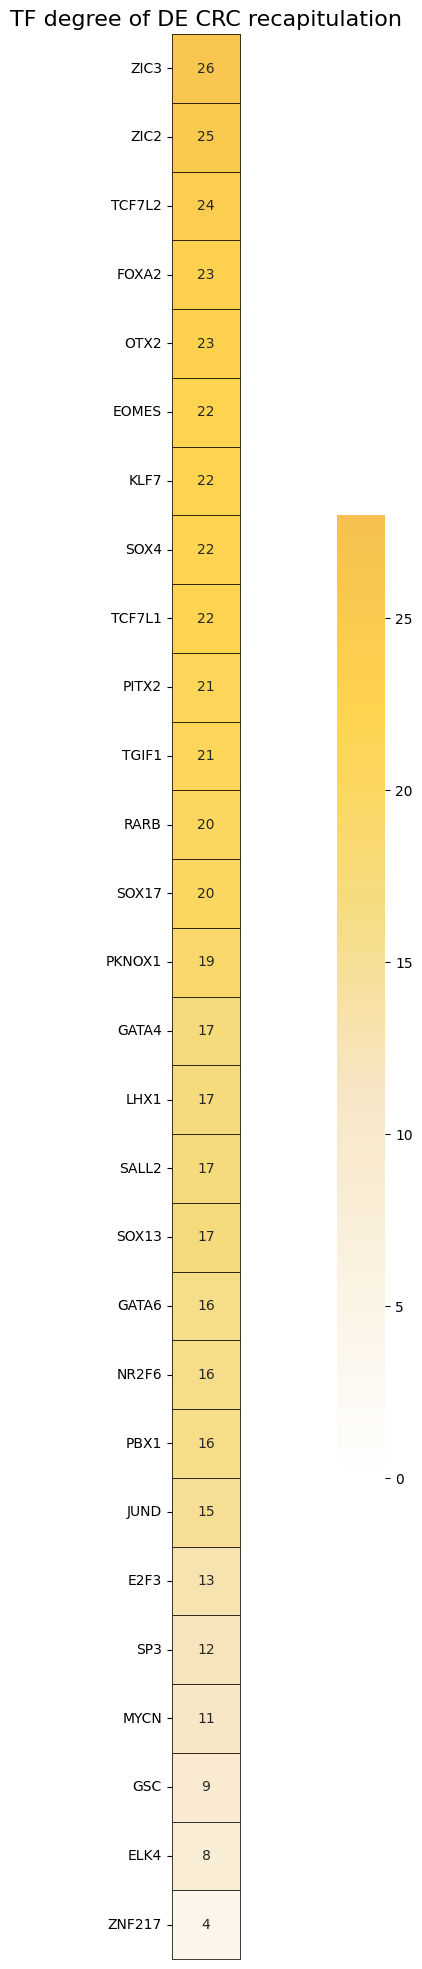

In [392]:
title = 'TF degree of DE CRC recapitulation'
degree_recap, edgeCountDict = plotDegree(CRC = deCRC, title = title, cmap = deDegreeCmap, vmax=28)

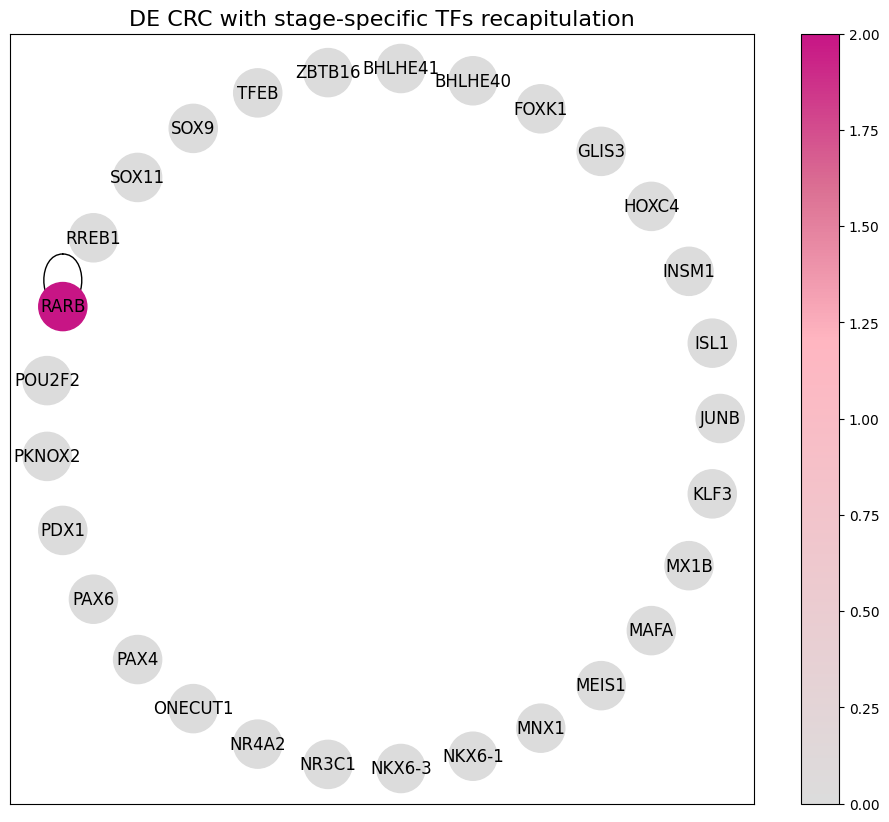

In [363]:
title = 'DE CRC with stage-specific TFs recapitulation'
plotNetwork(edgeCountDict=edgeCountDict, title=title, cmap=BetaCRCcmap)

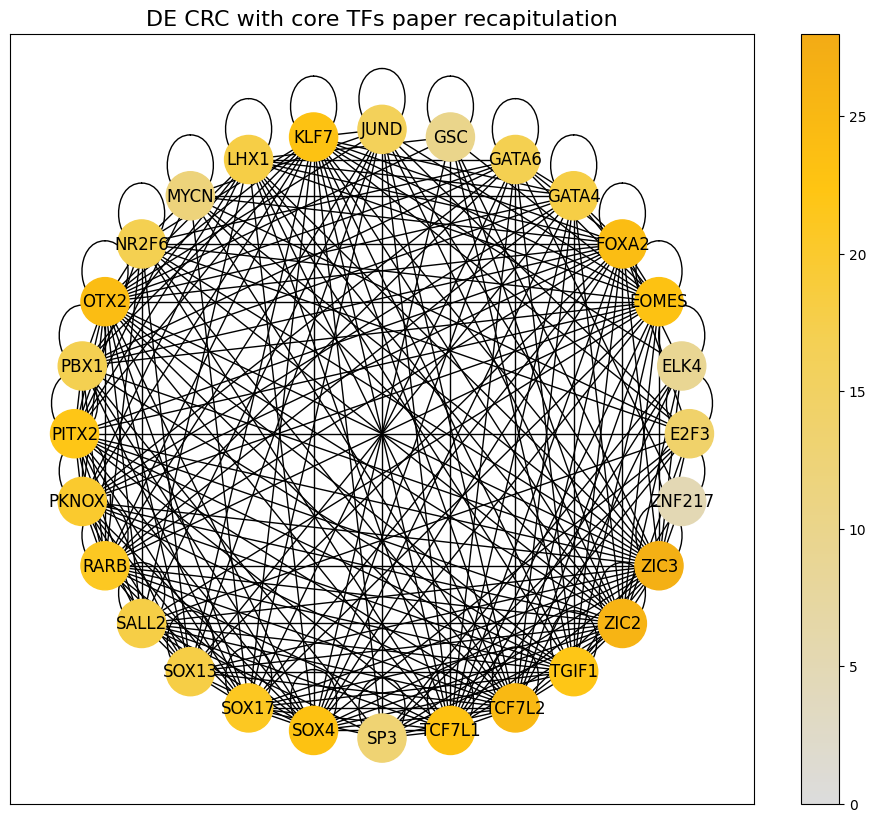

In [364]:
# DE CRC composed of all autoregulatory TFs
nodeList = sorted(degree['TF'].to_list())

edgeList = []
for pair in edgeCountDict.keys():
    edgeList.append(pair)

# constructing network
title = 'DE CRC with core TFs paper recapitulation'
plt.figure(figsize=(12,10), dpi=100)
plt.title(title, fontsize=16)
G = nx.Graph()
G.add_nodes_from(nodeList)
G.add_edges_from(edgeList)
pos = nx.circular_layout(G)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
node_color = [G.degree(v) for v in G]
network = nx.draw_networkx_nodes(G, pos,node_color=node_color,cmap=deCRCcmap, node_size=1200, vmin=0, vmax=28)
plt.colorbar(network)
plt.savefig('./visualization/'+'_'.join(title.split())+'.pdf', dpi=100)

In [407]:
degree_paper['rank'] = degree_paper.degree.rank(method="min", ascending=False)
print(degree_paper)

        TF  degree  rank
0     ZIC3      28   1.0
1    FOXA2      27   2.0
4   TCF7L2      27   2.0
3     KLF7      26   4.0
7     OTX2      26   4.0
5     SOX4      26   4.0
9   TCF7L1      26   4.0
2      YY1      26   4.0
12    ZIC2      26   4.0
6    EOMES      25  10.0
10   SOX17      25  10.0
11    JUND      24  12.0
17  SREBF1      24  12.0
14   GATA4      23  14.0
13   PITX2      23  14.0
16  PKNOX1      23  14.0
24   TGIF1      23  14.0
8    FOXO3      22  18.0
18    LHX1      22  18.0
15    RARB      22  18.0
22   GATA6      20  21.0
20    PBX1      19  22.0
19    REST      19  22.0
25    E2F3      18  24.0
21   NR2F6      18  24.0
23     SP3      17  26.0
28    HES1      14  27.0
26    MYCN      13  28.0
27     GSC      10  29.0
29  ZNF217       4  30.0


In [408]:
degree_recap['rank'] = degree_recap.degree.rank(method="min", ascending=False)
print(degree_recap)

        TF  degree  rank
0     ZIC3      26   1.0
1     ZIC2      25   2.0
2   TCF7L2      24   3.0
9    FOXA2      23   4.0
4     OTX2      23   4.0
5    EOMES      22   6.0
12    KLF7      22   6.0
7     SOX4      22   6.0
8   TCF7L1      22   6.0
6    PITX2      21  10.0
11   TGIF1      21  10.0
13    RARB      20  12.0
14   SOX17      20  12.0
10  PKNOX1      19  14.0
15   GATA4      17  15.0
3     LHX1      17  15.0
16   SALL2      17  15.0
23   SOX13      17  15.0
24   GATA6      16  19.0
18   NR2F6      16  19.0
25    PBX1      16  19.0
17    JUND      15  22.0
21    E2F3      13  23.0
26     SP3      12  24.0
20    MYCN      11  25.0
22     GSC       9  26.0
19    ELK4       8  27.0
27  ZNF217       4  28.0


In [410]:
pd.merge(degree, degree_recap, on="TF", how="outer", suffixes=('_paper', '_recapitulation')).fillna('-')

TF degree_paper rank_paper degree_recapitulation rank_recapitulation
0     ZIC3         28.0        1.0                  26.0                 1.0
1    FOXA2         27.0        2.0                  23.0                 4.0
2   TCF7L2         27.0        2.0                  24.0                 3.0
3     KLF7         26.0        4.0                  22.0                 6.0
4     OTX2         26.0        4.0                  23.0                 4.0
5     SOX4         26.0        4.0                  22.0                 6.0
6   TCF7L1         26.0        4.0                  22.0                 6.0
7      YY1         26.0        4.0                     -                   -
8     ZIC2         26.0        4.0                  25.0                 2.0
9    EOMES         25.0       10.0                  22.0                 6.0
10   SOX17         25.0       10.0                  20.0                12.0
11    JUND         24.0       12.0                  15.0                22.0
12  SREBF1         24.0       12.0                     -                   -
13   GATA4         23.0       14.0                  17.0                15.0
14   PITX2         23.0       14.0                  21.0                10.0
15  PKNOX1         23.0       14.0                  19.0                14.0
16   TGIF1         23.0       14.0                  21.0                10.0
17   FOXO3         22.0       18.0                     -                   -
18    LHX1         22.0       18.0                  17.0                15.0
19    RARB         22.0       18.0                  20.0                12.0
20   GATA6         20.0       21.0                  16.0                19.0
21    PBX1         19.0       22.0                  16.0                19.0
22    REST         19.0       22.0                     -                   -
23    E2F3         18.0       24.0                  13.0                23.0
24   NR2F6         18.0       24.0                  16.0                19.0
25     SP3         17.0       26.0                  12.0                24.0
26    HES1         14.0       27.0                     -                   -
27    MYCN         13.0       28.0                  11.0                25.0
28     GSC         10.0       29.0                   9.0                26.0
29  ZNF217          4.0       30.0                   4.0                28.0
30   SALL2            -          -                  17.0                15.0
31   SOX13            -          -                  17.0                15.0
32    ELK4            -          -                   8.0                27.0

## <u>each step of function plotDegree</u>

In [69]:
cliqueList = []
for i in betaCRCinPaper['CRC_TFs']:
    cliqueList.append(eval(i))
print(cliqueList[0])

['FOXK1', 'HES1', 'FOXA2', 'MAFA', 'RREB1', 'MEIS2', 'PDX1', 'PAX6', 'MEF2D', 'SMAD3', 'NFE2L2', 'INSM1', 'RFX2', 'KLF13', 'RARA', 'SOX13', 'NKX2-2']


In [29]:
# calculating degree for each node (TF) in the CRC
## degree of undirected graph
## including the degree of self-loop
## reason why using dict rather list: query speed of dictionary >> list

### 1. counting edges
edgeCountDict = {}
for clique in cliqueList:
    for TF in clique:
        for (source, target) in zip([TF] * len(clique), clique):
        # this for loop generate interactions (source, target) in each clique
            if (source, target) not in edgeCountDict.keys():
                edgeCountDict[(source, target)] = 0
            else:
                edgeCountDict[(source, target)] += 1
                
### 2. counting the occurrences of source nodes among edges => degree of nodes
degreeDict = {}
for (source, target) in edgeCountDict.keys():
    if source not in degreeDict.keys():
        degreeDict[source] = 1
    else:
        degreeDict[source] += 1

dict(list(degreeDict.items())[0:5])

{'FOXK1': 45, 'HES1': 31, 'FOXA2': 45, 'MAFA': 43, 'RREB1': 44}

In [30]:
# into sorted df
degree = pd.DataFrame(degreeDict.items(), columns=['TF','degree'])
# degree = pd.DataFrame.from_dict(degreeDict, orient='index')
degree.sort_values(by=['degree', 'TF'], ascending=[False, True], inplace=True)
degree.head(5)

TF  degree
2   FOXA2      45
0   FOXK1      45
26  TEAD1      45
11  INSM1      44
5   MEIS2      44

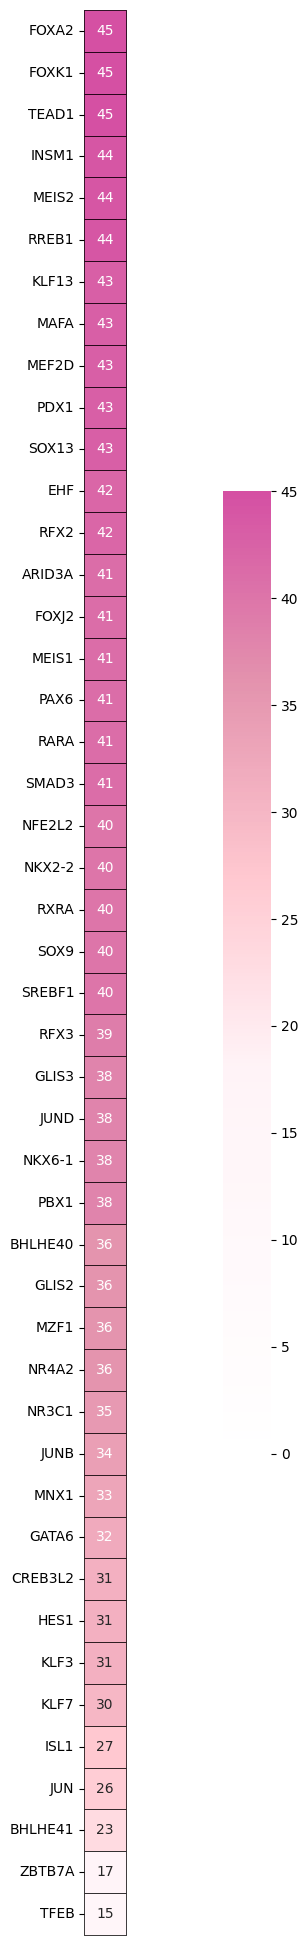

In [62]:
# degree heatmap
plt.figure(figsize=(25,25), dpi=100)
cbar_kws = {'shrink':0.5,}
kwargs = {'alpha':.75, 'linewidths':0.5, 'linecolor':'k', 'cmap': mycmap, 'vmin': 0, 'vmax': 45,
          'clip_on':False, 'annot': True, 'fmt':'g', 'square': True, 'xticklabels': False,
          'yticklabels': degree['TF'].to_list(),
          'cbar_kws': cbar_kws}
# sns.heatmap([degree['degree'].to_list()], **kwargs)
sns.heatmap(np.array([degree['degree'].to_list()]).T, **kwargs)
plt.yticks(rotation=0)
plt.savefig('./visualization/degree_Beta_paper.pdf', dpi=100)
# plt.show()

In [ ]:
# don't run
# calculating CRC scores
## 1. counting the occurences of the TFs accross the loops
dicoTFinloopsCounts={}
for clique in cliqueList:
    for TF in clique:
        if dicoTFinloopsCounts.__contains__(TF):
            dicoTFinloopsCounts[TF] += 1
        else:
            dicoTFinloopsCounts[TF] = 1

print(dict(list(dicoTFinloopsCounts.items())[0:5]))

## 2. turning into a df
dicoTFinloopsCountsDict = pd.DataFrame.from_dict(dicoTFinloopsCounts, orient='index')
dicoTFinloopsCountsDict.head(5)

## 3. calculating scores
cliqueRanking = []
for clique in cliqueList:
    cliqueScore = 0
    for TF in clique:
        cliqueScore = (float(cliqueScore) + (float(dicoTFinloopsCounts[TF])))
    cliqueRanking.append((clique, cliqueScore/len(clique), len(clique)))
print(cliqueRanking[:1])

## <u>each step of function plotNetwork</u>

[('FOXK1', 'FOXK1'), ('FOXK1', 'MAFA'), ('FOXK1', 'RREB1'), ('FOXK1', 'PDX1'), ('FOXK1', 'PAX6')]


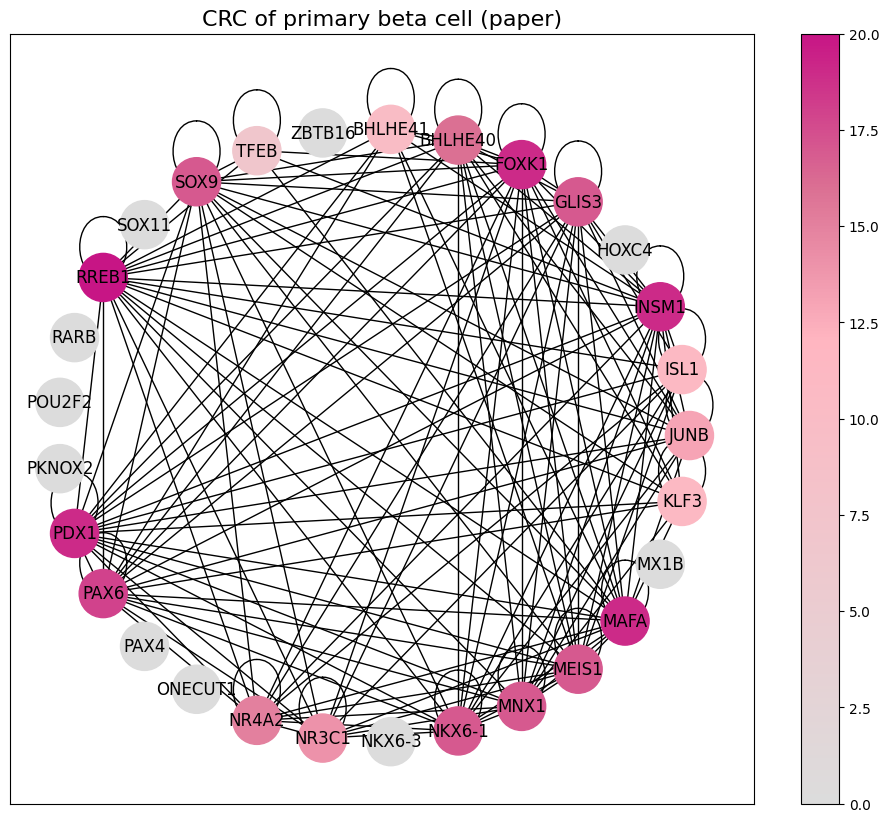

In [205]:
# in order to recreate similar network as in the paper, extract nodes of the network from the paper
nodeListPaper = ['JUNB', 'ISL1', 'INSM1', 'HOXC4', 'GLIS3', 'FOXK1', 'BHLHE40', 'BHLHE41', 'ZBTB16', 'TFEB', 'SOX9', 'SOX11', 'RREB1', 'RARB', 'POU2F2', 'PKNOX2', 'PDX1', 'PAX6', 'PAX4', 'ONECUT1', 'NR4A2', 'NR3C1', 'NKX6-3', 'NKX6-1', 'MNX1', 'MEIS1', 'MAFA', 'MX1B', 'KLF3']

edgeListPaper = []
for pair in edgeCountDict.keys():
    if nodeListPaper.count(pair[0]) and nodeListPaper.count(pair[1]):
        edgeListPaper.append(pair)
        
print(edgeListPaper[:5]) 

# constructing network
title = 'CRC of primary beta cell (paper)'
plt.figure(figsize=(12,10), dpi=100)
plt.title(title, fontsize=16)
G = nx.Graph()
G.add_nodes_from(nodeListPaper)
G.add_edges_from(edgeListPaper)
pos = nx.circular_layout(G)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
node_color = [G.degree(v) for v in G]
network = nx.draw_networkx_nodes(G, pos,node_color=node_color,cmap=mycmap, node_size=1200, vmin=0)
plt.colorbar(network)
plt.show()